<a href="https://colab.research.google.com/github/budhrajaankita/Data200/blob/main/data200_gradproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Comorbidities on COVID-19 Mortality

Authors - Ankita Budhraja (3038515599), Hrishikesh Nagaraju (3038515222), Mayank Bhushan (3038587476)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Background**

The COVID-19 pandemic that started in March of 2020 spread across United States and the world. As of Dec 2022, COVID-19 has led to 1.1 million deaths in the United States. In some cases, the patients also had an underlying health condition (also known as comorbodity) that accompanied the COVID-19 infection. In this study, we explore and evaluate the association of underlying condition and COVID-19 mortality.

## Read Packages

In [ ]:
import os
import pandas as pd
import zipfile
import glob
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, 
    precision_recall_curve, PrecisionRecallDisplay)
import imblearn
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score


# Datasets

The data for this study has been obtained from two publicly available datasets from Center for Systems Science and Engineering (CSSE) at Johns Hopkins University and the National Center for Health Statistics. The following datasets were used to explore the association of comorbodities on COVID-19 mortality.

1. US COVID-19 Daily Reports (CSSE at Johns Hopkins University)
2. Provisional COVID-19 Deaths by Sex and Age (NCHS)
3. Conditions Contributing to COVID-19 Deaths, by State and Age, Provisional 2020-2022 (NCHS)

# Dataset 1 - US COVID-19 Daily Reports (CSSE at Johns Hopkins University)

This dataset comes from the data repository for the  Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). This effort is supported by ESRI Living Atlas Team and the Johns Hopkins University Applied Physics Lab (JHU APL). The dataset consists of day level files which aggregate the daily COVID-19 reports of each USA state.


In [ ]:
%cd '/content/drive/MyDrive/DATA200/Dataset A'

/content/drive/MyDrive/DATA200/Dataset A


In [ ]:
daily_reports_all = pd.read_csv("daily_reports_all.csv")

In [ ]:
# Convert daily_report_date to a datetime format
daily_reports_all['daily_report_date'] = pd.to_datetime(daily_reports_all['daily_report_date'], format='%m-%d-%Y')

## Summary Statistics

In [ ]:
daily_reports_all['daily_report_date'].agg(['min','max'])

min   2020-04-12
max   2022-03-28
Name: daily_report_date, dtype: datetime64[ns]

The daily reports dataset contains data points starting from April 2020 and uptill March 2022.

In [ ]:
daily_count = daily_reports_all.groupby('daily_report_date').agg(count = ('daily_report_date','count')).reset_index()

In [ ]:
daily_count.groupby('count').count()

,daily_report_date
count,
58,698
59,18


In [ ]:
daily_count[daily_count['count'] != 58]

,daily_report_date,count
0,2020-04-12,59
1,2020-04-13,59
2,2020-04-14,59
3,2020-04-15,59
4,2020-04-16,59
5,2020-04-17,59
6,2020-04-18,59
7,2020-04-19,59
8,2020-04-20,59
9,2020-04-21,59


## Transforming Daily Cumulative Indicators to Daily Absolute Indicators

In [ ]:
daily_reports_all = daily_reports_all.sort_values(by=['Province_State','daily_report_date'])

In [ ]:
# Converting Cumulative Confirmed to Daily Confirmed
daily_reports_all['Daily Confirmed'] = daily_reports_all.groupby(['Province_State'])['Confirmed'].diff().fillna(0)

# Converting Cumulative Death to Daily Death
daily_reports_all['Daily Deaths'] = daily_reports_all.groupby(['Province_State'])['Deaths'].diff().fillna(0)

# Converting Cumulative Recovered to Daily Recovered
daily_reports_all['Daily Recovered'] = daily_reports_all.groupby(['Province_State'])['Recovered'].diff().fillna(0)

# Converting Cumulative Active to Daily Active
daily_reports_all['Daily Active'] = daily_reports_all.groupby(['Province_State'])['Active'].diff().fillna(0)

# Converting Cumulative Tested to Daily Tested
daily_reports_all['Daily Tested'] = daily_reports_all.groupby(['Province_State'])['People_Tested'].diff().fillna(0)

In [ ]:
daily_reports_all['year'] = pd.DatetimeIndex(daily_reports_all['daily_report_date']).year

daily_reports_all['month'] = pd.DatetimeIndex(daily_reports_all['daily_report_date']).month_name()

daily_reports_all['month_year'] = daily_reports_all['daily_report_date'].dt.to_period('M')

daily_reports_all['month_year_name'] = daily_reports_all['month'].astype(str) + ' ' + daily_reports_all['year'].astype(str)

## Missing Values Check

In [ ]:
missing_value_check = (daily_reports_all.isnull().sum()/len(daily_reports_all)*100).sort_values(ascending=False)

In [ ]:
missing_value_check

People_Hospitalized     87.654648
Hospitalization_Rate    87.654648
People_Tested           71.559236
Mortality_Rate          71.051365
Recovered               63.601791
Active                  63.601791
Total_Test_Results      32.368940
Case_Fatality_Ratio     30.296539
Testing_Rate             3.928176
Lat                      3.490107
Long_                    3.490107
Incident_Rate            3.490107
Last_Update              0.045732
FIPS                     0.045732
Daily Active             0.000000
Province_State           0.000000
Daily Tested             0.000000
year                     0.000000
Daily Deaths             0.000000
month                    0.000000
month_year               0.000000
Daily Recovered          0.000000
ISO3                     0.000000
Daily Confirmed          0.000000
daily_report_date        0.000000
Country_Region           0.000000
UID                      0.000000
Deaths                   0.000000
Confirmed                0.000000
month_year_nam

In [ ]:
daily_reports = daily_reports_all.drop(['Hospitalization_Rate','People_Hospitalized','People_Tested','Mortality_Rate','Recovered','Active','Total_Test_Results','Case_Fatality_Ratio'],axis = 1)

## Total Confirmed Cases and Deaths By Month

In [ ]:
monthwise_agg = daily_reports_all.groupby(['month_year','month_year_name'])['Daily Confirmed','Daily Deaths'].agg(total_confirmed = ('Daily Confirmed','sum'),
                                                                             total_deaths = ('Daily Deaths','sum')).reset_index()

<ipython-input-17-fc381ac16709>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthwise_agg = daily_reports_all.groupby(['month_year','month_year_name'])['Daily Confirmed','Daily Deaths'].agg(total_confirmed = ('Daily Confirmed','sum'),


In [ ]:
# %cd '/home/jovyan/fa22/grad_proj/outputs'
# deaths_by_month.to_csv('deaths_by_month.csv',index=True)

In [ ]:
monthwise_agg

,month_year,month_year_name,total_confirmed,total_deaths
0,2020-04,April 2020,514715.0,40915.0
1,2020-05,May 2020,715412.0,41213.0
2,2020-06,June 2020,868643.0,22538.0
3,2020-07,July 2020,1902973.0,26091.0
4,2020-08,August 2020,1507973.0,30200.0
5,2020-09,September 2020,1201100.0,23486.0
6,2020-10,October 2020,1921600.0,24402.0
7,2020-11,November 2020,4443058.0,39621.0
8,2020-12,December 2020,6565288.0,80927.0
9,2021-01,January 2021,6146892.0,96653.0


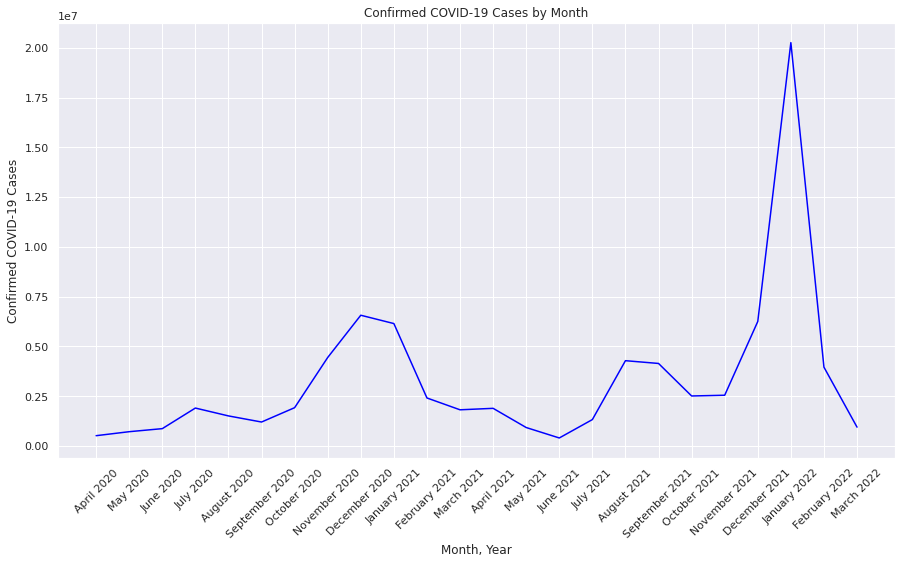

In [ ]:
sns.set()
plt.figure(figsize=(15,8))

sns.lineplot(x=monthwise_agg['month_year_name'], y=monthwise_agg['total_confirmed'], color = "blue")
plt.title("Confirmed COVID-19 Cases by Month")
plt.xlabel("Month, Year")
plt.ylabel("Confirmed COVID-19 Cases")
plt.xticks(rotation=45)
plt.show()

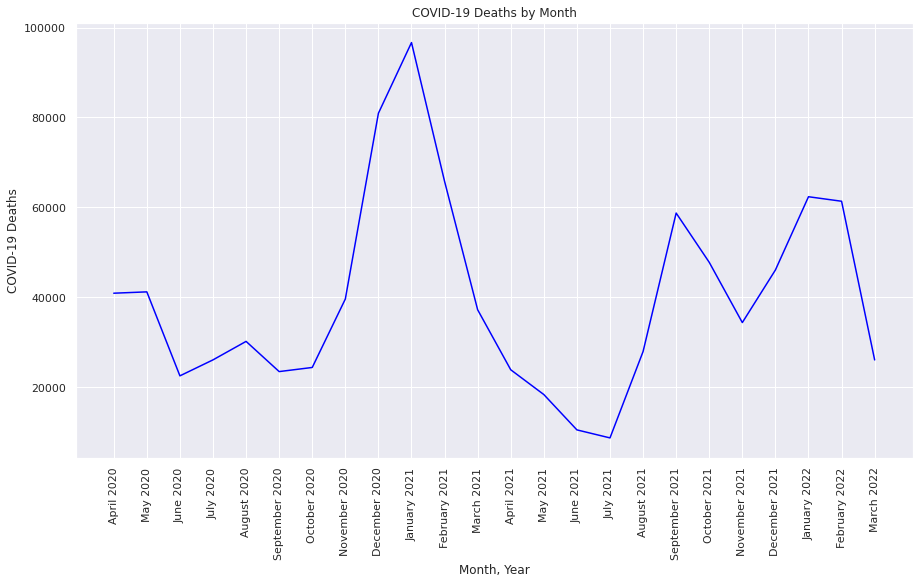

In [ ]:
plt.figure(figsize=(15,8))

sns.lineplot(x=monthwise_agg['month_year_name'], y=monthwise_agg['total_deaths'], color = "blue")
plt.title("COVID-19 Deaths by Month")
plt.xlabel("Month, Year")
plt.ylabel("COVID-19 Deaths")
plt.xticks(rotation=90)
plt.show()

## Day level trend

In [ ]:
daily_agg = daily_reports_all.groupby(['daily_report_date'])['Daily Confirmed','Daily Deaths'].agg(total_confirmed = ('Daily Confirmed','sum'),
                                                                             total_deaths = ('Daily Deaths','sum')).reset_index()

<ipython-input-22-18ba092ab34c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_agg = daily_reports_all.groupby(['daily_report_date'])['Daily Confirmed','Daily Deaths'].agg(total_confirmed = ('Daily Confirmed','sum'),


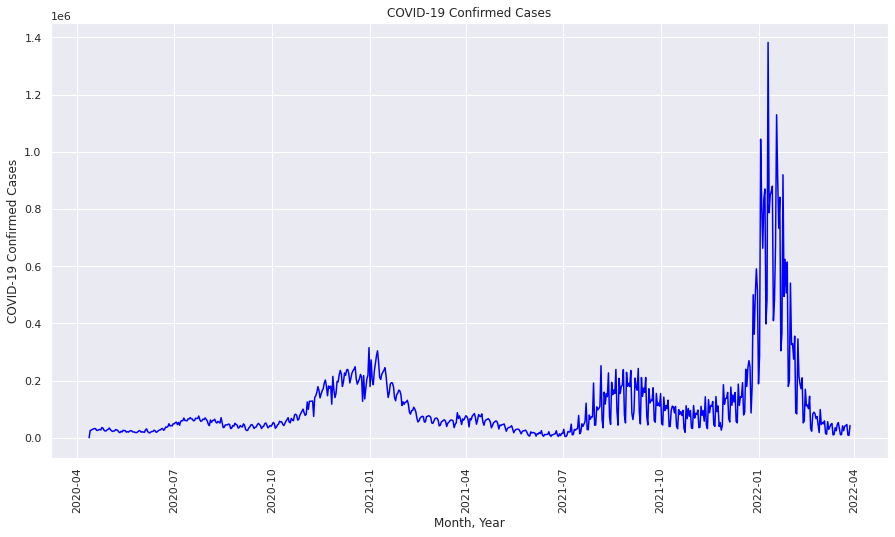

In [ ]:
plt.figure(figsize=(15,8))

sns.lineplot(x=daily_agg['daily_report_date'], y=daily_agg['total_confirmed'], color = "blue")
plt.title("COVID-19 Confirmed Cases")
plt.xlabel("Month, Year")
plt.ylabel("COVID-19 Confirmed Cases")
plt.xticks(rotation=90)
plt.show()

In [ ]:
fig = px.line(daily_agg, x='daily_report_date', y='total_confirmed')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
fig = px.line(daily_reports_all, x='daily_report_date', y='Daily Confirmed', color='Province_State').update_traces(
    mode="lines"
)

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": t.name,
                    "method": "restyle",
                    "args": [{"visible": [t2.name == t.name for t2 in fig.data]}],
                }
                for t in fig.data
            ]
        }
    ]
)

fig.show()

# Dataset 2 - Provisional COVID-19 Deaths by Sex and Age (NCHS)

This data is provided by the National Center for Health Statistics. It contains data about COVID-19 deaths by sex (Male & Female) and various age groups across all states of the United States of America including Puerto Rico. Additionally, it also includes data about total deaths (Irrespective of cause), deaths due to Pneumonia and influenza. An interesting point to note is that death counts between 1-9 have been supressed to comply with NCHS confidentiality standards. The data is available at various levels of aggregation: Total, by each year and by each month, the lowest granularity being the month level. The data starts from 2020-01-01  2022-03-19.


In [ ]:
%cd '/content/drive/MyDrive/DATA200/Dataset A'
df = pd.read_csv("cdc_death_counts_by_sex_age_state.csv")

/content/drive/MyDrive/DATA200/Dataset A


In [ ]:
df.head(10)

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0,855731.0,504882.0,10684.0,1334231.0,NaN
1,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,Under 1 year,242.0,41777.0,495.0,28.0,28.0,736.0,NaN
2,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,0-17 years,933.0,74176.0,1460.0,252.0,204.0,2342.0,NaN
3,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,1-4 years,113.0,7791.0,293.0,29.0,70.0,447.0,NaN
4,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,5-14 years,296.0,12438.0,424.0,96.0,82.0,705.0,NaN
5,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,15-24 years,2545.0,79772.0,2240.0,1134.0,97.0,3740.0,NaN
6,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,18-29 years,6044.0,140833.0,5161.0,2890.0,170.0,8470.0,NaN
7,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,25-34 years,10803.0,168507.0,8792.0,5401.0,256.0,14427.0,NaN
8,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,30-39 years,17609.0,208720.0,13974.0,9074.0,352.0,22829.0,NaN
9,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,35-44 years,26952.0,249728.0,21174.0,14244.0,411.0,34244.0,NaN


In [ ]:
df.describe(include='all') 

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
count,85374,85374,85374,85374,82620.000000,74358.00000,85374,85374,85374,63928.000000,7.312100e+04,59953.000000,64091.000000,70846.000000,6.080000e+04,55996
unique,1,27,27,3,NaN,NaN,54,3,17,NaN,NaN,NaN,NaN,NaN,NaN,1
top,03/23/2022,01/01/2020,03/19/2022,By Month,NaN,NaN,United States,All Sexes,All Ages,NaN,NaN,NaN,NaN,NaN,NaN,One or more data cells have counts between 1-9...
freq,85374,8262,8262,74358,NaN,NaN,1581,28458,5022,NaN,NaN,NaN,NaN,NaN,NaN,55996
mean,NaN,NaN,NaN,NaN,2020.700000,6.00000,NaN,NaN,NaN,412.120651,2.809326e+03,385.232782,214.114337,3.780736,5.917720e+02,NaN
std,NaN,NaN,NaN,NaN,0.690415,3.55905,NaN,NaN,NaN,6509.621827,4.664565e+04,5912.020733,3399.111422,76.082218,9.122656e+03,NaN
min,NaN,NaN,NaN,NaN,2020.000000,1.00000,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,2020.000000,3.00000,NaN,NaN,NaN,0.000000,4.300000e+01,0.000000,0.000000,0.000000,0.000000e+00,NaN
50%,NaN,NaN,NaN,NaN,2021.000000,6.00000,NaN,NaN,NaN,13.000000,1.560000e+02,20.000000,0.000000,0.000000,2.800000e+01,NaN
75%,NaN,NaN,NaN,NaN,2021.000000,9.00000,NaN,NaN,NaN,78.000000,6.880000e+02,89.000000,39.000000,0.000000,1.340000e+02,NaN


In [ ]:
df_c = df.copy()

## Missing Values Check

In [ ]:
print(df.isnull().mean().round(2).mul(100).sort_values(ascending=False))

Footnote                                    34.0
Pneumonia Deaths                            30.0
Pneumonia, Influenza, or COVID-19 Deaths    29.0
COVID-19 Deaths                             25.0
Pneumonia and COVID-19 Deaths               25.0
Influenza Deaths                            17.0
Total Deaths                                14.0
Month                                       13.0
Year                                         3.0
Data As Of                                   0.0
Start Date                                   0.0
End Date                                     0.0
Group                                        0.0
State                                        0.0
Sex                                          0.0
Age Group                                    0.0
dtype: float64


We observe that a significant proportion of deaths related to Pneumonia and Influenza are missing. Since this data is not important to the objective of this project, we will drop these columns.

In [ ]:
df_c = df_c.drop(['Pneumonia Deaths','Pneumonia and COVID-19 Deaths','Influenza Deaths','Pneumonia, Influenza, or COVID-19 Deaths','Footnote'],axis = 1)

In [ ]:
df_c.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths
0,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0
1,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,Under 1 year,242.0,41777.0
2,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,0-17 years,933.0,74176.0
3,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,1-4 years,113.0,7791.0
4,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,5-14 years,296.0,12438.0


In [ ]:
#Converting start date end date to datetime and checking max and min values
df_c['DT_Start_Date']= pd.to_datetime(df_c['Start Date'])
df_c['DT_End_Date']= pd.to_datetime(df_c['End Date'])
print("Minimum start date: {}".format(min(df_c['DT_Start_Date'])))
print("Max end date: {}".format(max(df_c['DT_End_Date'])))

#Creating new columns to manipulate dates easily
df_c['Impacted Year'] = pd.DatetimeIndex(df_c['DT_Start_Date']).year
df_c['Impacted Month'] = df_c['DT_Start_Date'].dt.month_name().str[:]
df_c['month_year'] = df_c['Impacted Month'].astype(str) + ' ' + df_c['Impacted Year'].astype(str)
df_c

Minimum start date: 2020-01-01 00:00:00
Max end date: 2022-03-19 00:00:00


,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,DT_Start_Date,DT_End_Date,Impacted Year,Impacted Month,month_year
0,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0,2020-01-01,2022-03-19,2020,January,January 2020
1,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,Under 1 year,242.0,41777.0,2020-01-01,2022-03-19,2020,January,January 2020
2,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,0-17 years,933.0,74176.0,2020-01-01,2022-03-19,2020,January,January 2020
3,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,1-4 years,113.0,7791.0,2020-01-01,2022-03-19,2020,January,January 2020
4,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,5-14 years,296.0,12438.0,2020-01-01,2022-03-19,2020,January,January 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85369,03/23/2022,03/01/2022,03/19/2022,By Month,2022.0,3.0,Puerto Rico,Female,50-64 years,0.0,0.0,2022-03-01,2022-03-19,2022,March,March 2022
85370,03/23/2022,03/01/2022,03/19/2022,By Month,2022.0,3.0,Puerto Rico,Female,55-64 years,0.0,0.0,2022-03-01,2022-03-19,2022,March,March 2022
85371,03/23/2022,03/01/2022,03/19/2022,By Month,2022.0,3.0,Puerto Rico,Female,65-74 years,0.0,0.0,2022-03-01,2022-03-19,2022,March,March 2022
85372,03/23/2022,03/01/2022,03/19/2022,By Month,2022.0,3.0,Puerto Rico,Female,75-84 years,0.0,0.0,2022-03-01,2022-03-19,2022,March,March 2022


## Total COVID-19 Deaths in the United States by Sex

In [ ]:
df_c_sex= df_c.loc[(df_c["Age Group"]=="All Ages")  & (df_c["State"]=="United States") & (df_c["Group"]=="By Total")]
df_c_sex

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,DT_Start_Date,DT_End_Date,Impacted Year,Impacted Month,month_year
0,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0,2020-01-01,2022-03-19,2020,January,January 2020
17,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,All Ages,539611.0,3963382.0,2020-01-01,2022-03-19,2020,January,January 2020
34,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Female,All Ages,434671.0,3557168.0,2020-01-01,2022-03-19,2020,January,January 2020


[Text(0.5, 1.0, 'Total COVID-19 Deaths in the US by Sex')]

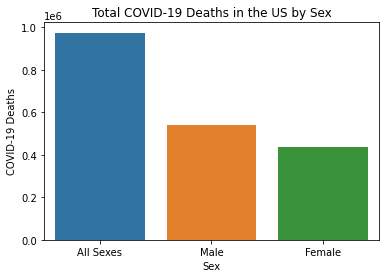

In [ ]:
sns.barplot(x = 'Sex', y = 'COVID-19 Deaths', data = df_c_sex).set(title='Total COVID-19 Deaths in the US by Sex')

## Total COVID-19 Deaths in the United States by Age Groups

In [ ]:
df_c_age_groups= df_c.loc[(df_c["Sex"]=="All Sexes")  & (df_c["State"]=="United States") & (df_c["Group"]=="By Total")]
df_c_age_groups.head()

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,DT_Start_Date,DT_End_Date,Impacted Year,Impacted Month,month_year
0,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,All Ages,974282.0,7520550.0,2020-01-01,2022-03-19,2020,January,January 2020
1,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,Under 1 year,242.0,41777.0,2020-01-01,2022-03-19,2020,January,January 2020
2,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,0-17 years,933.0,74176.0,2020-01-01,2022-03-19,2020,January,January 2020
3,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,1-4 years,113.0,7791.0,2020-01-01,2022-03-19,2020,January,January 2020
4,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,All Sexes,5-14 years,296.0,12438.0,2020-01-01,2022-03-19,2020,January,January 2020


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text major ticklabel objects>)

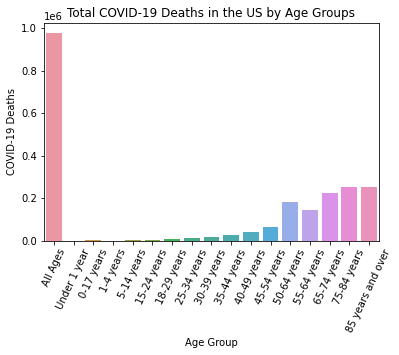

In [ ]:
sns.barplot(x = 'Age Group', y = 'COVID-19 Deaths', data = df_c_age_groups).set(title='Total COVID-19 Deaths in the US by Age Groups')
plt.xticks(rotation=65)

We observe from above that "All Ages" column is making it difficult for us to see the data from individual age groups clearly.

In [ ]:
df_c_age_groups_withoutallages= df_c.loc[(df["Sex"]=="All Sexes")  & (df_c["State"]=="United States") & (df_c["Group"]=="By Total") & (df_c["Age Group"]!="All Ages")]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

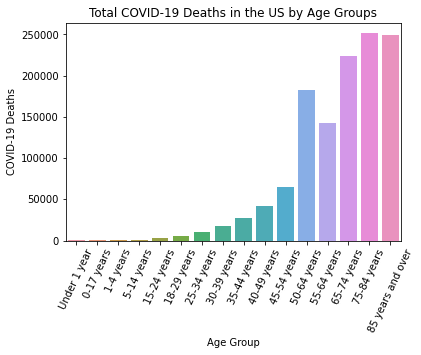

In [ ]:
sns.barplot(x = 'Age Group', y = 'COVID-19 Deaths', data = df_c_age_groups_withoutallages).set(title='Total COVID-19 Deaths in the US by Age Groups')
plt.xticks(rotation=65)

In [ ]:
df_c_age_groups_withoutallages= df_c.loc[(df["Sex"] != "All Sexes")  & (df_c["State"]=="United States") & (df_c["Group"]=="By Total") & (df_c["Age Group"]!="All Ages")]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

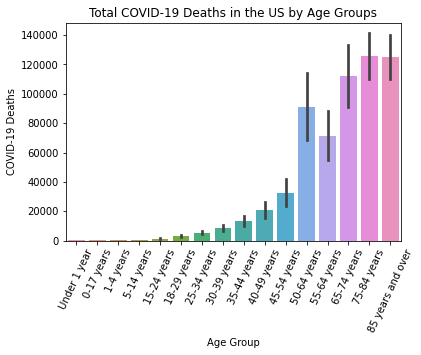

In [ ]:
sns.barplot(x = 'Age Group', y = 'COVID-19 Deaths', data = df_c_age_groups_withoutallages).set(title='Total COVID-19 Deaths in the US by Age Groups')
plt.xticks(rotation=65)

Since many of the above age groups overlap over one another. We will select only few of them so that we can see a clear distribution. Since the values for COVID-19 deaths in lower age groups are much lower as compared to the higher age groups, we will club the 1st group as 0-17 Years, Next would be 18-29, 30-39, 40-49, 50-64, 65-74, 75-84 and lastly, 85+.

In [ ]:
df_c_age_groups_new= df_c.loc[(df["Sex"] != "All Sexes")  & (df_c["State"]=="United States") & (df_c["Group"]=="By Total") & (df_c["Age Group"].isin(['0-17 years','18-29 years','30-39 years','40-49 years','50-64 years','65-74 years','75-84 years','85 years and over']))]
df_c_age_groups_new

,Data As Of,Start Date,End Date,Group,Year,Month,State,Sex,Age Group,COVID-19 Deaths,Total Deaths,DT_Start_Date,DT_End_Date,Impacted Year,Impacted Month,month_year
19,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,0-17 years,502.0,43340.0,2020-01-01,2022-03-19,2020,January,January 2020
23,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,18-29 years,3678.0,102666.0,2020-01-01,2022-03-19,2020,January,January 2020
25,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,30-39 years,10932.0,141298.0,2020-01-01,2022-03-19,2020,January,January 2020
27,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,40-49 years,26469.0,199361.0,2020-01-01,2022-03-19,2020,January,January 2020
29,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,50-64 years,113886.0,784130.0,2020-01-01,2022-03-19,2020,January,January 2020
31,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,65-74 years,133217.0,892018.0,2020-01-01,2022-03-19,2020,January,January 2020
32,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,75-84 years,141149.0,951762.0,2020-01-01,2022-03-19,2020,January,January 2020
33,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Male,85 years and over,109778.0,848807.0,2020-01-01,2022-03-19,2020,January,January 2020
36,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Female,0-17 years,431.0,30836.0,2020-01-01,2022-03-19,2020,January,January 2020
40,03/23/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Female,18-29 years,2366.0,38167.0,2020-01-01,2022-03-19,2020,January,January 2020


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

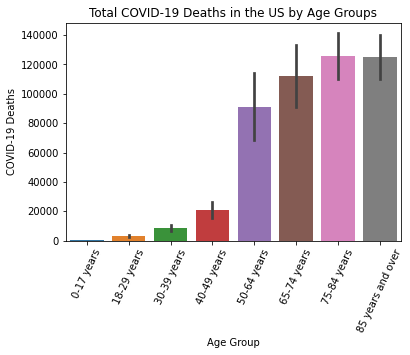

In [ ]:
sns.barplot(x = 'Age Group', y = 'COVID-19 Deaths', data = df_c_age_groups_new).set(title='Total COVID-19 Deaths in the US by Age Groups')
plt.xticks(rotation=65)

## Total COVID-19 Deaths by Sex and Age groups

In [ ]:
deaths_sex_age = df_c_age_groups_new.groupby(['Sex','Age Group'], sort=False)["COVID-19 Deaths"].sum().reset_index()
deaths_sex_age

,Sex,Age Group,COVID-19 Deaths
0,Male,0-17 years,502.0
1,Male,18-29 years,3678.0
2,Male,30-39 years,10932.0
3,Male,40-49 years,26469.0
4,Male,50-64 years,113886.0
5,Male,65-74 years,133217.0
6,Male,75-84 years,141149.0
7,Male,85 years and over,109778.0
8,Female,0-17 years,431.0
9,Female,18-29 years,2366.0


In [ ]:
px.scatter(deaths_sex_age, x='Age Group', y='COVID-19 Deaths', 
           hover_data=['Sex'],
           color='Sex', size='COVID-19 Deaths', size_max=30)

We observe that in almost all age groups significantly more males died than females. 

## Yearly COVID-19 Deaths in the US by Sex

   Impacted Year        Sex  COVID-19 Deaths
0           2020  All Sexes         385475.0
1           2020     Female         176103.0
2           2020       Male         209372.0
3           2021  All Sexes         461036.0
4           2021     Female         202150.0
5           2021       Male         258886.0
6           2022  All Sexes         127771.0
7           2022     Female          56418.0
8           2022       Male          71353.0


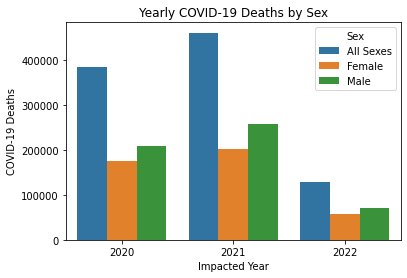

In [ ]:
year_by_sex = df_c.loc[(df_c["Group"] == "By Year") & (df_c["Age Group"] == "All Ages") & (df_c["State"] == "United States")]
year_by_sex = year_by_sex.reset_index()
yearly_deaths_by_sex = year_by_sex.groupby(["Impacted Year","Sex",])["COVID-19 Deaths"].sum().reset_index()
print(yearly_deaths_by_sex)
sns.barplot(x = 'Impacted Year', y = 'COVID-19 Deaths', hue = 'Sex', data = yearly_deaths_by_sex).set(title='Yearly COVID-19 Deaths by Sex')
plt.show()

## Yearly COVID-19 Deaths in the US by Age Group

    Impacted Year          Age Group  COVID-19 Deaths
0            2020         0-17 years            198.0
1            2020          1-4 years             25.0
2            2020        15-24 years            616.0
3            2020        18-29 years           1484.0
4            2020        25-34 years           2622.0
5            2020        30-39 years           4291.0
6            2020        35-44 years           6787.0
7            2020        40-49 years          11328.0
8            2020        45-54 years          18331.0
9            2020         5-14 years             68.0
10           2020        50-64 years          56775.0
11           2020        55-64 years          45575.0
12           2020        65-74 years          82291.0
13           2020        75-84 years         106272.0
14           2020  85 years and over         122836.0
15           2020       Under 1 year             52.0
16           2021         0-17 years            574.0
17           2021          1

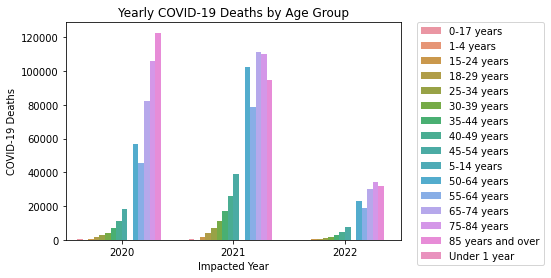

In [ ]:
year_by_age_group = df_c.loc[(df_c["Group"] == "By Year") & (df_c["Sex"] == "All Sexes") & (df_c["State"] == "United States") & (df_c["Age Group"]!="All Ages")]
year_by_age_group = year_by_age_group.reset_index()
yearly_deaths_by_age_group = year_by_age_group.groupby(["Impacted Year","Age Group",])["COVID-19 Deaths"].sum().reset_index()
print(yearly_deaths_by_age_group)
sns.barplot(x = 'Impacted Year', y = 'COVID-19 Deaths', hue = 'Age Group', data = yearly_deaths_by_age_group).set(title='Yearly COVID-19 Deaths by Age Group')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Monthly COVID-19 Deaths by Sex 

In [ ]:
deaths_sex_all = df_c.loc[(df_c["Sex"] != "All Sexes") & (df_c["Group"] == "By Month") & (df_c["Age Group"] != "All Ages") & (df_c["State"] == "United States")]
deaths_sex_yearly = deaths_sex_all.groupby(['Sex','month_year'], sort=False)["COVID-19 Deaths"].sum().reset_index()
deaths_sex_yearly

,Sex,month_year,COVID-19 Deaths
0,Male,January 2020,3.0
1,Female,January 2020,4.0
2,Male,February 2020,18.0
3,Female,February 2020,16.0
4,Male,March 2020,5728.0
5,Female,March 2020,3359.0
6,Male,April 2020,44578.0
7,Female,April 2020,33716.0
8,Male,May 2020,24139.0
9,Female,May 2020,21185.0


In [ ]:
fig = px.line(deaths_sex_yearly, x='month_year', y='COVID-19 Deaths', color='Sex').update_traces(
    mode="lines"
)

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": t.name,
                    "method": "restyle",
                    "args": [{"visible": [t2.name == t.name for t2 in fig.data]}],
                }
                for t in fig.data
            ]
        }
    ]
)

fig.show()

## Monthly COVID-19 Deaths by Age Group

In [ ]:
deaths_age_all = df_c.loc[(df_c["Sex"] == "All Sexes") & (df_c["Group"] == "By Month") & (df_c["Age Group"] != "All Ages") & (df_c["State"] == "United States")]
deaths_age_yearly = deaths_age_all.groupby(['Age Group','month_year'], sort=False)["COVID-19 Deaths"].sum().reset_index()
deaths_age_yearly


,Age Group,month_year,COVID-19 Deaths
0,Under 1 year,January 2020,0.0
1,0-17 years,January 2020,0.0
2,1-4 years,January 2020,0.0
3,5-14 years,January 2020,0.0
4,15-24 years,January 2020,0.0
...,...,...,...
427,50-64 years,March 2022,833.0
428,55-64 years,March 2022,680.0
429,65-74 years,March 2022,1366.0
430,75-84 years,March 2022,1586.0


In [ ]:
fig = px.line(deaths_age_yearly, x='month_year', y='COVID-19 Deaths', color='Age Group').update_traces(
    mode="lines"
)

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": t.name,
                    "method": "restyle",
                    "args": [{"visible": [t2.name == t.name for t2 in fig.data]}],
                }
                for t in fig.data
            ]
        }
    ]
)

fig.show()

# Dataset 3 - Conditions Contributing to COVID-19 Deaths, by State and Age, Provisional 2020-2022 (NCHS)


This data about Conditions Contributing to COVID-19 Deaths, by State and Age comes from CDC (Centers for Disease Control and Prevention) provided by NCHS. The data shows the types of health conditions and contributing causes mentioned in conjunction with deaths involving COVID-19. For over 5% of these deaths, COVID-19 was the only cause mentioned on the death certificate. For deaths with conditions or causes in addition to COVID-19, on average, there were 4.0 additional conditions or causes per death. 


In [ ]:
%cd '/content/drive/MyDrive/DATA200/Dataset A'
dbc = pd.read_csv("cdc_death_counts_by_conditons.csv")


/content/drive/MyDrive/DATA200/Dataset A


## Missing Values Check

In [ ]:
# rows with COVID-19 as condition
covid_condition = dbc.loc[dbc['Condition']=='COVID-19']
print(covid_condition.shape)
check = covid_condition.loc[(covid_condition["COVID-19 Deaths"] != covid_condition["Number of Mentions"]) & (covid_condition["COVID-19 Deaths"].isnull())]
print(check.shape)

check = covid_condition.loc[(covid_condition["COVID-19 Deaths"] == covid_condition["Number of Mentions"])]
print(check.shape)
#Check missing values %
print(dbc.isnull().mean().round(4).mul(100).sort_values(ascending=False))


(16740, 14)
(3306, 14)
(13434, 14)
Flag                  71.97
COVID-19 Deaths       28.03
Number of Mentions    27.18
Month                 12.90
Year                   3.23
Data As Of             0.00
Start Date             0.00
End Date               0.00
Group                  0.00
State                  0.00
Condition Group        0.00
Condition              0.00
ICD10_codes            0.00
Age Group              0.00
dtype: float64


## Transform date formats and add relevant columns

In [ ]:
#convert start date end date to datetime and check max and min values
dbc['DT_Start_Date']= pd.to_datetime(dbc['Start Date'])
dbc['DT_End_Date']= pd.to_datetime(dbc['End Date'])
print("Minimum start date: {}".format(min(dbc['DT_Start_Date'])))
print("Max end date: {}".format(max(dbc['DT_End_Date'])))

dbc['Impacted Year'] = pd.DatetimeIndex(dbc['DT_Start_Date']).year
# dbc['month_year'] = pd.to_datetime(dbc['DT_Start_Date']).dt.to_period('M')
dbc['Impacted Month'] = dbc['DT_Start_Date'].dt.month_name().str[:3]
dbc['month_year'] = dbc['Impacted Month'].astype(str) + ' ' + dbc['Impacted Year'].astype(str)
dbc

Minimum start date: 2020-01-01 00:00:00
Max end date: 2022-03-19 00:00:00


,Data As Of,Start Date,End Date,Group,Year,Month,State,Condition Group,Condition,ICD10_codes,Age Group,COVID-19 Deaths,Number of Mentions,Flag,DT_Start_Date,DT_End_Date,Impacted Year,Impacted Month,month_year
0,03/20/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,1277.0,1334.0,NaN,2020-01-01,2022-03-19,2020,Jan,Jan 2020
1,03/20/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,5351.0,5551.0,NaN,2020-01-01,2022-03-19,2020,Jan,Jan 2020
2,03/20/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,14089.0,14644.0,NaN,2020-01-01,2022-03-19,2020,Jan,Jan 2020
3,03/20/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,35120.0,36444.0,NaN,2020-01-01,2022-03-19,2020,Jan,Jan 2020
4,03/20/2022,01/01/2020,03/19/2022,By Total,NaN,NaN,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,76708.0,79386.0,NaN,2020-01-01,2022-03-19,2020,Jan,Jan 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385015,03/20/2022,11/01/2021,11/30/2021,By Month,2021.0,11.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,28.0,28.0,NaN,2021-11-01,2021-11-30,2021,Nov,Nov 2021
385016,03/20/2022,12/01/2021,12/31/2021,By Month,2021.0,12.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,51.0,51.0,NaN,2021-12-01,2021-12-31,2021,Dec,Dec 2021
385017,03/20/2022,01/01/2022,01/31/2022,By Month,2022.0,1.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,0.0,0.0,NaN,2022-01-01,2022-01-31,2022,Jan,Jan 2022
385018,03/20/2022,02/01/2022,02/28/2022,By Month,2022.0,2.0,Puerto Rico,COVID-19,COVID-19,U071,All Ages,0.0,0.0,NaN,2022-02-01,2022-02-28,2022,Feb,Feb 2022


In [ ]:
dbc['Year'] = dbc['Year'].astype('Int64')
dbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385020 entries, 0 to 385019
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Data As Of          385020 non-null  object        
 1   Start Date          385020 non-null  object        
 2   End Date            385020 non-null  object        
 3   Group               385020 non-null  object        
 4   Year                372600 non-null  Int64         
 5   Month               335340 non-null  float64       
 6   State               385020 non-null  object        
 7   Condition Group     385020 non-null  object        
 8   Condition           385020 non-null  object        
 9   ICD10_codes         385020 non-null  object        
 10  Age Group           385020 non-null  object        
 11  COVID-19 Deaths     277098 non-null  float64       
 12  Number of Mentions  280357 non-null  float64       
 13  Flag                107922 no

## COVID-19 Deaths for all ages in the US with ONLY covid-19 as condition group

[Text(0.5, 1.0, 'Total COVID-19 Deaths with only COVID-19 underlying condition')]

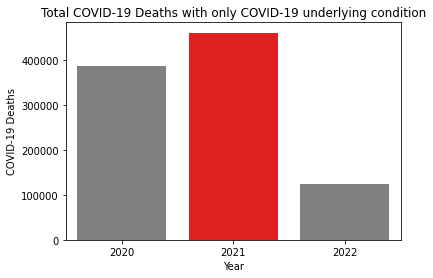

In [ ]:
#check rows by years for all ages, in US, with only covid-19 as condition group
year_all_ages_us_only_covid = dbc.loc[(dbc["Group"] == "By Year") & (dbc["Age Group"] == "All Ages") & (dbc["State"] == "United States") & (dbc["Condition Group"] == "COVID-19")]
deaths_by_condition_covid = year_all_ages_us_only_covid.groupby(["Year","Condition Group"])["COVID-19 Deaths"].sum().reset_index()
colors = ['grey' if (x < max(deaths_by_condition_covid["COVID-19 Deaths"])) else 'red' for x in deaths_by_condition_covid["COVID-19 Deaths"] ]
sns.barplot(x = 'Year', y = 'COVID-19 Deaths', data = deaths_by_condition_covid, palette=colors).set(title='Total COVID-19 Deaths with only COVID-19 underlying condition')


In [ ]:
# # Yearwise Total COVID-19 Deaths by Condition Group
# #check rows by years for all ages in US
year_all_ages_us = dbc.loc[(dbc["Group"] == "By Year") & (dbc["Age Group"] == "All Ages") & (dbc["State"] == "United States")]
year_all_ages_us = year_all_ages_us.reset_index()
total_deaths = year_all_ages_us.groupby(["Year"])["COVID-19 Deaths"].sum().reset_index()
# sns.barplot(x = 'Year', y = 'COVID-19 Deaths', data = total_deaths).set(title='Total COVID-19 Deaths with all underlying conditions')
# plt.show()


## Yearwise COVID-19 Deaths for each Condition Group


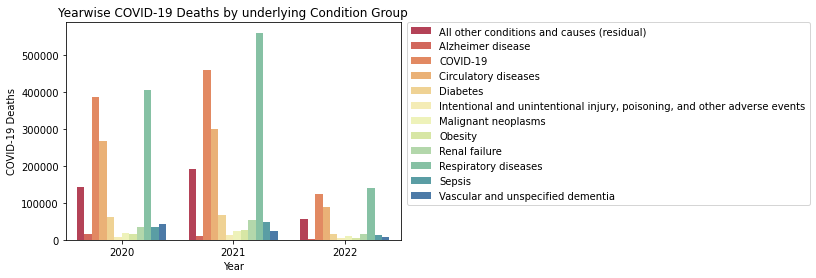

In [ ]:
# Yearwise COVID-19 Deaths by Condition Group
deaths_by_condition_group = year_all_ages_us.groupby(["Year","Condition Group"])["COVID-19 Deaths"].sum().reset_index()
sns.barplot(x = 'Year', y = 'COVID-19 Deaths', hue = 'Condition Group', data = deaths_by_condition_group, palette = "Spectral").set(title='Yearwise COVID-19 Deaths by underlying Condition Group')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
# deaths_by_condition_group

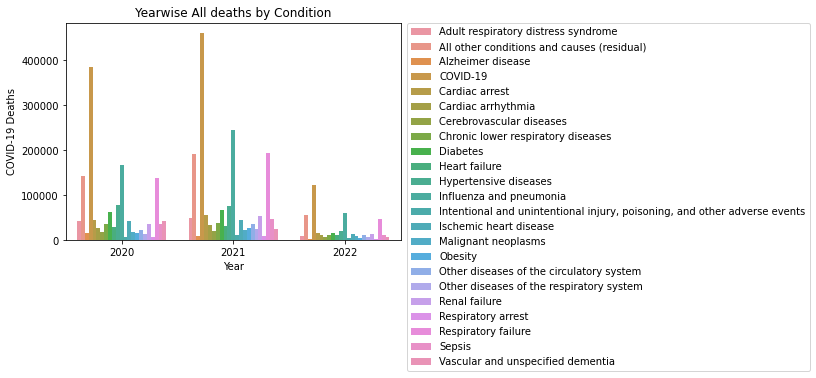

In [ ]:
deaths_by_condition = year_all_ages_us.groupby(["Year","Condition"])["COVID-19 Deaths"].sum().reset_index()
sns.barplot(x = 'Year', y = 'COVID-19 Deaths', hue = 'Condition', data = deaths_by_condition).set(title="Yearwise All deaths by Condition")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
deaths_by_condition["Condition"] = deaths_by_condition["Condition"].replace('Inten.*', 'Injury, Poisoning etc', regex=True)


# Graphs per each condition yearwise
# g = sns.FacetGrid(deaths_by_condition, row="Condition", aspect=.75, height=3.5)
# g.map(sns.barplot, "Year", "COVID-19 Deaths", palette="Set2", order=None)


## Monthwise Deaths for all ages and all underlying conditions


[Text(0.5, 1.0, 'Deaths due to all conditions')]

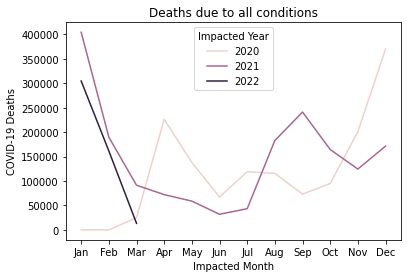

In [ ]:
#Deaths per month all ages, by month, for US, all conditions
deaths_by_cond = dbc.copy()
deaths_bymonth_all = deaths_by_cond.loc[(deaths_by_cond["Group"] == "By Month") & (deaths_by_cond["Age Group"] == "All Ages") & (deaths_by_cond["State"] == "United States")]
deaths_bymonth_all.reset_index()
sum_deaths_bymonth_all = deaths_bymonth_all.groupby(['Impacted Year','Impacted Month'], sort=False)["COVID-19 Deaths"].sum().reset_index()
sum_deaths_bymonth_all

sns.lineplot(x='Impacted Month', y='COVID-19 Deaths', hue='Impacted Year', data=sum_deaths_bymonth_all, ci=None).set(title='Deaths due to all conditions')


## Monthwise Deaths for all ages but ONLY underlying health condition being COVID


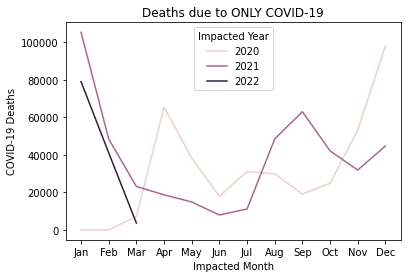

In [ ]:
#Deaths per month all ages, by month, for US, covid only
deaths_bymonth_covid = deaths_by_cond.loc[(deaths_by_cond["Group"] == "By Month") & (deaths_by_cond["Age Group"] == "All Ages") & (deaths_by_cond["State"] == "United States") & (deaths_by_cond["Condition Group"] == "COVID-19")]
deaths_bymonth_covid.reset_index()
sns.lineplot(x='Impacted Month', y='COVID-19 Deaths', hue='Impacted Year', data=deaths_bymonth_covid).set(title='Deaths due to ONLY COVID-19')
sum_deaths_bymonth_covid = deaths_bymonth_covid.groupby(['Impacted Year','Impacted Month'], sort=False)["COVID-19 Deaths"].sum().reset_index()
# sum_deaths_bymonth_covid


In [ ]:
deaths_byages_all = deaths_by_cond.loc[(deaths_by_cond["Group"] == "By Month") & (deaths_by_cond["Age Group"] != "All Ages") & (deaths_by_cond["Age Group"] != "Not stated") & (deaths_by_cond["State"] == "United States")]
deaths_byages_cg = deaths_byages_all.groupby(['Condition Group','Age Group','month_year','Condition'], sort=False)["COVID-19 Deaths"].sum().reset_index()
deaths_byages_cg

px.scatter(deaths_byages_cg, x='month_year', y='COVID-19 Deaths', 
           hover_data=['Condition Group'],
           color='Age Group', size='COVID-19 Deaths', size_max=30)


In [ ]:
fig = px.line(deaths_byages_cg, x='month_year', y='COVID-19 Deaths', color='Age Group').update_traces(
    mode="lines"
)

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": t.name,
                    "method": "restyle",
                    "args": [{"visible": [t2.name == t.name for t2 in fig.data]}],
                }
                for t in fig.data
            ]
        }
    ]
)

fig.show()

In [ ]:
fig = px.line(deaths_byages_cg, x='month_year', y='COVID-19 Deaths', color='Condition Group').update_traces(
    mode="lines"
)

fig.update_xaxes(rangeslider_visible=True)

fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": t.name,
                    "method": "restyle",
                    "args": [{"visible": [t2.name == t.name for t2 in fig.data]}],
                }
                for t in fig.data
            ]
        }
    ]
)

fig.show()

In [ ]:
px.bar(deaths_byages_cg, x ='COVID-19 Deaths', y = 'month_year',
       color = 'Condition', orientation ='h',
       hover_data = ['Age Group', 'Condition Group'])

In [ ]:
px.bar(deaths_byages_cg, x="month_year", y="COVID-19 Deaths", color="Condition Group", 
       hover_data=["Condition Group"], height=400)


In [ ]:
# px.bar(deaths_byages_cg, x="month_year", y="COVID-19 Deaths", color="Condition", 
#        hover_data=["Condition"], height=400)

In [ ]:
px.bar(deaths_byages_cg, x="month_year", y="COVID-19 Deaths", color="COVID-19 Deaths", hover_data=['Condition Group','Condition'], log_y=False, height=400)

In [ ]:
# g = sns.FacetGrid(deaths_byages_cg, row="Condition Group", col = "Age Group")
# g.map(sns.barplot, "COVID-19 Deaths", palette="Set2", order=None)


['Influenza and pneumonia' 'Chronic lower respiratory diseases'
 'Adult respiratory distress syndrome' 'Respiratory failure'
 'Respiratory arrest' 'Other diseases of the respiratory system'
 'Hypertensive diseases' 'Ischemic heart disease' 'Cardiac arrest'
 'Cardiac arrhythmia' 'Heart failure' 'Cerebrovascular diseases'
 'Other diseases of the circulatory system' 'Sepsis' 'Malignant neoplasms'
 'Diabetes' 'Obesity' 'Alzheimer disease'
 'Vascular and unspecified dementia' 'Renal failure'
 'Intentional and unintentional injury, poisoning, and other adverse events'
 'All other conditions and causes (residual)' 'COVID-19']
['Respiratory diseases' 'Circulatory diseases' 'Sepsis'
 'Malignant neoplasms' 'Diabetes' 'Obesity' 'Alzheimer disease'
 'Vascular and unspecified dementia' 'Renal failure'
 'Intentional and unintentional injury, poisoning, and other adverse events'
 'All other conditions and causes (residual)' 'COVID-19']


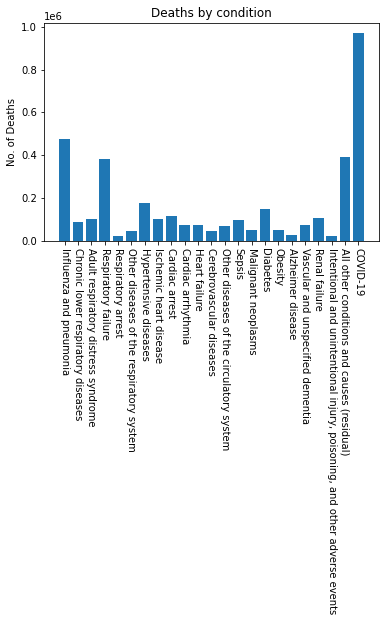

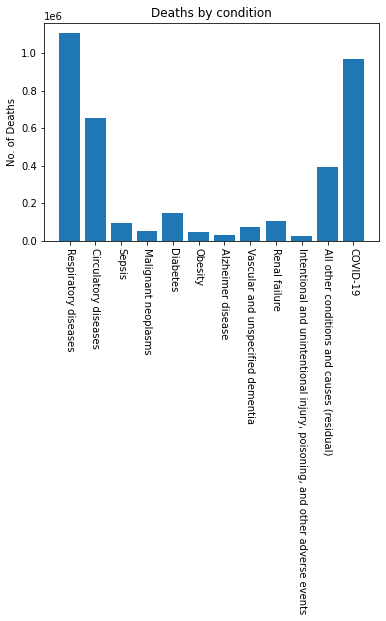

In [ ]:
main_data = dbc.copy()
main_data = main_data[['Group','Condition','Condition Group','COVID-19 Deaths', 'Age Group', 'State']]
main_data = main_data[main_data['Group'] == 'By Total']
main_data = main_data.dropna()
all_conditions = main_data['Condition'].unique()
all_cg = main_data['Condition Group'].unique()
Percentage = (main_data['Condition Group'].value_counts()/main_data['Condition Group'].count())*100
# main_data['Percentage'] = a
deaths = []
cg_deaths = []
print(all_conditions)
print(all_cg)

for condition in all_cg:
    d = main_data[(main_data['Condition Group'] == condition) & (main_data['Age Group'] == 'All Ages') & (main_data['State'] == 'United States')]
    death_sum = d['COVID-19 Deaths'].sum()
    cg_deaths.append(death_sum)
cg_deaths

for condition in all_conditions:
    d = main_data[(main_data['Condition'] == condition) & (main_data['Age Group'] == 'All Ages') & (main_data['State'] == 'United States')]
    death_sum = d['COVID-19 Deaths'].sum()
    deaths.append(death_sum)
deaths

plt.bar(all_conditions, deaths)
plt.xticks(rotation = -90)
plt.ylabel('No. of Deaths')
plt.title('Deaths by condition')
plt.show()

plt.bar(all_cg, cg_deaths)
plt.xticks(rotation = -90)
plt.ylabel('No. of Deaths')
plt.title('Deaths by condition')
plt.show()


In [ ]:
main_data_ages = main_data[(main_data['Age Group'] != 'Not stated') & (main_data['Age Group'] != 'All Ages')]
px.bar(main_data_ages, x = 'COVID-19 Deaths', y = 'Age Group', color = 'Condition Group',orientation ='h',  height = 500)

In [ ]:
top_5_conditions = {'Condition': all_conditions, 'Deaths': deaths}
top_5_conditions = pd.DataFrame(top_5_conditions)
top_5 = top_5_conditions.nlargest(6, 'Deaths')
from plotly.figure_factory import create_table
  
colorscale = [[0, '#4d004c'], [.5, '#f2e5ff'], [1, '#ffffff']]
table = create_table(top_5, colorscale=colorscale)
top_5.set_index('Condition', inplace=True)
table


# Modelling

This section documents the exploration and construction of a model to understand how comorbodities impact mortality due to COVID-19.

## PCA

Since we have a large number of features in our dataset we perform a principal component analysis to identify the components that most explain the dataset.

In [ ]:
%cd '/content/drive/MyDrive/DATA200/Dataset A'

/content/drive/MyDrive/DATA200/Dataset A


In [ ]:
conditions = pd.read_csv("cdc_death_counts_by_conditons.csv")

In [ ]:
conditions_total = conditions[(conditions['Group'] == 'By Total') & (conditions['State'] != 'United States')  & (conditions['Age Group'] == 'All Ages')]

In [ ]:
conditions_total = conditions_total[['State','Condition','COVID-19 Deaths']]

In [ ]:
conditions_total.fillna(0, inplace=True)

In [ ]:
age_sex = pd.read_csv("cdc_death_counts_by_sex_age_state.csv")

In [ ]:
age_sex = age_sex[(age_sex['Group'] == 'By Total') & (age_sex['Age Group'] == 'All Ages') & (age_sex['Sex'] == 'All Sexes')]

In [ ]:
age_sex = age_sex[age_sex['State'] != 'United States']

In [ ]:
age_sex = age_sex[['State','COVID-19 Deaths','Total Deaths']]

In [ ]:
age_sex = age_sex.rename({'COVID-19 Deaths': 'Total COVID-19 Deaths'}, axis='columns')

In [ ]:
merged = conditions_total.set_index('State').join(age_sex.set_index('State'))

In [ ]:
merged['perc_covid_deaths'] = merged['COVID-19 Deaths']/merged['Total COVID-19 Deaths']

In [ ]:
merged = merged.reset_index()

In [ ]:
merged_wide = pd.pivot(merged, index=['State'], columns = 'Condition',values = 'perc_covid_deaths') 

In [ ]:
merged_wide.columns.name = None

In [ ]:
merged_standardized = (merged_wide - np.mean(merged_wide,axis=0))/np.std(merged_wide,axis=0)

In [ ]:
u, s, vt = np.linalg.svd(merged_standardized, full_matrices = False)
u, s, vt

(array([[ 0.17916501,  0.17661994,  0.0785192 , ...,  0.00460767,
          0.03817394,  0.02357541],
        [ 0.05749042, -0.01825524, -0.03780047, ..., -0.18781604,
         -0.03951869,  0.14616321],
        [ 0.14745228, -0.01445974, -0.06193258, ...,  0.08415154,
         -0.13524443,  0.09341981],
        ...,
        [ 0.02812339, -0.00359264,  0.01290324, ..., -0.13196793,
          0.1347547 , -0.171716  ],
        [-0.29250044, -0.10579562,  0.09915686, ..., -0.20149965,
         -0.11320979, -0.07138671],
        [-0.15652201, -0.09078331, -0.02886816, ...,  0.06571466,
         -0.01299497, -0.33234339]]),
 array([21.43571406, 15.11455096, 11.75135217,  8.48996603,  7.46298732,
         7.15631909,  5.78544728,  5.25587023,  5.13156582,  4.89822843,
         4.4399208 ,  4.06556971,  3.86545579,  3.34076255,  2.78041915,
         2.69211257,  2.55328227,  2.37604984,  2.14960809,  1.68401488,
         1.53709206,  1.35655809,  1.18725009]),
 array([[ 5.60708704e-02, -2.782

In [ ]:
pcs = u*s

first_2_pcs = pd.DataFrame({
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
})
                         
first_2_pcs.head()

,pc1,pc2
0,3.840530,2.669531
1,1.232348,-0.275920
2,3.160745,-0.218553
3,2.195525,0.286099
4,2.253197,0.634329


In [ ]:
np.round(s**2 / sum(s**2), 2)

array([0.38, 0.19, 0.11, 0.06, 0.05, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

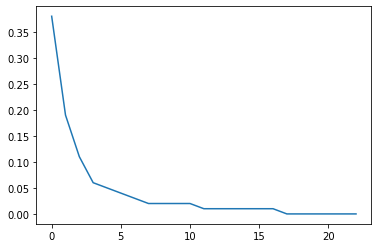

In [ ]:
plt.plot(np.round(s**2 / sum(s**2), 2))

PC1 explains 38% of the variation in the dataset. This is followed by PC2 which explains 19% and PC3 which explains 11% of the dataset.

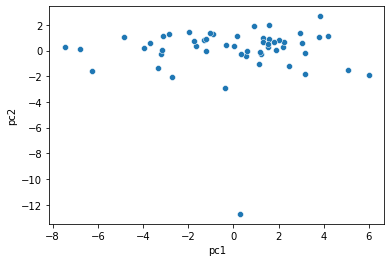

In [ ]:
sns.scatterplot(data = first_2_pcs, x = "pc1", y = "pc2");

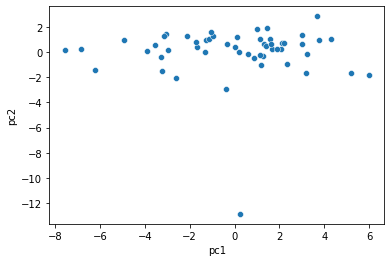

In [ ]:
# first, jitter the data
first_2_pcs_jittered = pd.DataFrame({
    'pc1': first_2_pcs['pc1'] +  np.random.normal(loc = 0, scale = 0.1, size = first_2_pcs.shape[0]),
    'pc2': first_2_pcs['pc2'] +  np.random.normal(loc = 0, scale = 0.1, size = first_2_pcs.shape[0])
})

# then, create a scatter plot
sns.scatterplot(x="pc1", y="pc2", data = first_2_pcs_jittered);

In [ ]:
import plotly.express as px

# get the state names from the standardized dataframe's index
first_2_pcs_jittered['state'] = merged_standardized.index

# show state names on hover
fig = px.scatter(first_2_pcs_jittered, x="pc1", y="pc2",
                hover_data={"state": True}); 

fig.show(); 

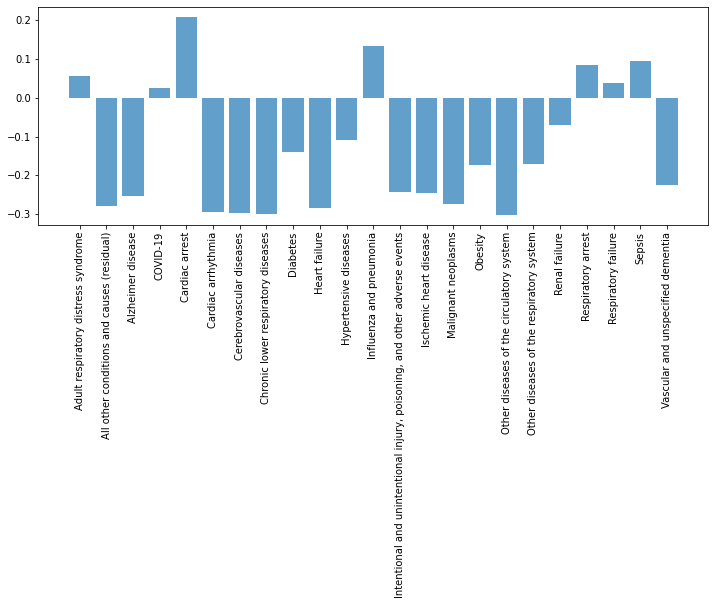

In [ ]:
def plot_pc(col_names, row_mat_vt, k):
    plt.bar(col_names, row_mat_vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);
    
plt.figure(figsize=(12, 4)) # adjusts size of plot
plot_pc(list(merged_standardized.columns), vt, 0);

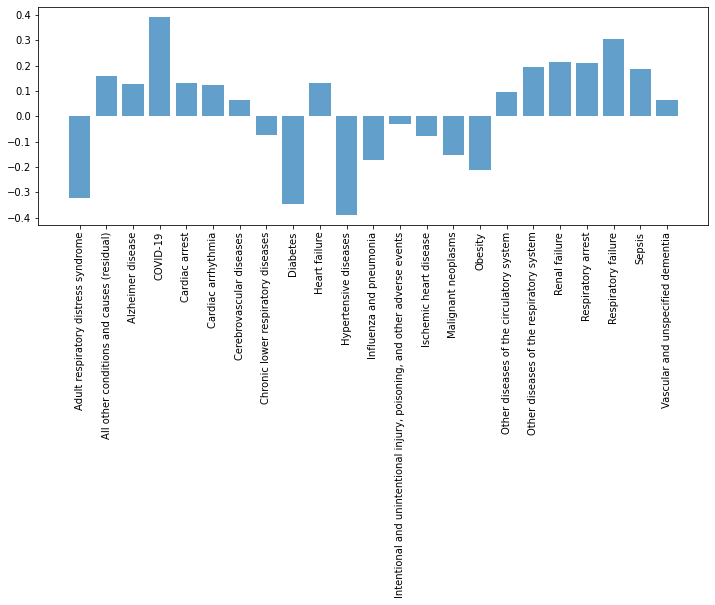

In [ ]:
def plot_pc(col_names, row_mat_vt, k):
    plt.bar(col_names, row_mat_vt[k, :], alpha=0.7)
    plt.xticks(col_names, rotation=90);
    
plt.figure(figsize=(12, 4)) # adjusts size of plot
plot_pc(list(merged_standardized.columns), vt, 1);

## Logistic Regression based on Condition Group

Logistic Regression is used to predict the categorical dependent variable using a given set of independent variables. In this case, condition groups and deaths are used. 
The sklearn package is used for Logistic regression to perform binary classification ie. to predict the probability that death (an event) will occur given a condition group.


In [ ]:
main_data = main_data.rename(columns={'Condition Group':'cg'})
deaths = pd.DataFrame(main_data['COVID-19 Deaths'])
cumm_cgs_score = {}
# ac_score = []
# cgs = []


## Model for Circulatory diseases with accuracy score

In [ ]:
circ = pd.DataFrame(main_data['cg'])
circ.cg[circ.cg != "Circulatory diseases"] = 0
circ.cg[circ.cg == "Circulatory diseases"] = 1
circ = np.array(circ)
circ = circ.astype('int')
circ_train, circ_test, circ_y_train, circ_y_test = train_test_split(deaths, circ, test_size = 0.25, random_state = 0)

circ_log = LogisticRegression().fit(circ_train, np.ravel(circ_y_train))
print(circ_log.intercept_)
print(circ_log.coef_)
c_preds = circ_log.predict(circ_test)
circ_Score = accuracy_score(c_preds, circ_y_test)
print('Score for Circulatory: {}'.format(circ_Score))
cumm_cgs_score["Circulatory diseases"] = circ_Score

[-0.86770937]
[[-9.77384204e-06]]
Score for Circulatory: 0.6969009826152683


## Model for Sepsis diseases with accuracy score

In [ ]:
sep = pd.DataFrame(main_data['cg'])
sep.cg[sep.cg != "Sepsis"] = 0
sep.cg[sep.cg == "Sepsis"] = 1
sep = np.array(sep)
sep = sep.astype('int')
sep_train, sep_test, sep_y_train, sep_y_test = train_test_split(deaths, sep, test_size = 0.25, random_state = 0)

sep_log = LogisticRegression().fit(sep_train, np.ravel(sep_y_train))
print(sep_log.intercept_)
print(sep_log.coef_)
s_preds = sep_log.predict(sep_test)
sep_score = accuracy_score(s_preds, sep_y_test)
print('Score for Sepsis: {}'.format(sep_score))

cumm_cgs_score["Sepsis"] = sep_score

[-3.05287447]
[[-8.30302716e-06]]
Score for Sepsis: 0.9618291761148904


## Model for Malignant neoplasms diseases with accuracy score

In [ ]:
neo = pd.DataFrame(main_data['cg'])
neo.cg[neo.cg != "Malignant neoplasms"] = 0
neo.cg[neo.cg == "Malignant neoplasms"] = 1
neo = np.array(neo)
neo = neo.astype('int')
neo_train, neo_test, neo_y_train, neo_y_test = train_test_split(deaths, neo, test_size = 0.25, random_state = 0)

neo_log = LogisticRegression().fit(neo_train, np.ravel(neo_y_train))
print(neo_log.intercept_)
print(neo_log.coef_)
n_preds = neo_log.predict(neo_test)
neo_score = accuracy_score(n_preds, neo_y_test)
print('Score for Neoplasms: {}'.format(neo_score))
cumm_cgs_score["Malignant neoplasms"] = neo_score


[-3.09583008]
[[-0.00011409]]
Score for Neoplasms: 0.9618291761148904


## Model for Diabetes with accuracy score

In [ ]:
diabetes = pd.DataFrame(main_data['cg'])
diabetes.cg[diabetes.cg != "Diabetes"] = 0
diabetes.cg[diabetes.cg == "Diabetes"] = 1
diabetes = diabetes.astype('int')
diabetes = np.array(diabetes)
diabetes_train, diabetes_test, diabetes_y_train, diabetes_y_test = train_test_split(deaths, diabetes, test_size = 0.25, random_state = 0)


diabetes_log = LogisticRegression().fit(diabetes_train, np.ravel(diabetes_y_train))
print(diabetes_log.intercept_)
print(diabetes_log.coef_)
d_preds = diabetes_log.predict(diabetes_test)
d_score = accuracy_score(d_preds, diabetes_y_test)
print('Score for Diabetes: {}'.format(d_score))

cumm_cgs_score["Diabetes"] = d_score



[-3.05418701]
[[-1.01177241e-05]]
Score for Diabetes: 0.9565381708238851


## Model for Obesity with accuracy score

In [ ]:
obe = pd.DataFrame(main_data['cg'])
obe.cg[obe.cg != "Obesity"] = 0
obe.cg[obe.cg == "Obesity"] = 1
obe = np.array(obe)
obe = obe.astype('int')
obe_train, obe_test, obe_y_train, obe_y_test = train_test_split(deaths, obe, test_size = 0.25, random_state = 0)

obe_log = LogisticRegression().fit(obe_train, np.ravel(obe_y_train))
print(obe_log.intercept_)
print(obe_log.coef_)
o_preds = obe_log.predict(obe_test)
o_score = accuracy_score(o_preds, obe_y_test)
print('Score for Obesity: {}'.format(o_score))
cumm_cgs_score["Obesity"] = o_score

[-3.04108269]
[[-8.97816429e-05]]
Score for Obesity: 0.9512471655328798


## Model for Alzheimer's with accuracy score

In [ ]:
alz = pd.DataFrame(main_data['cg'])
alz.cg[alz.cg != "Alzheimer disease"] = 0
alz.cg[alz.cg == "Alzheimer disease"] = 1
alz = np.array(alz)
alz = alz.astype('int')
alz_train, alz_test, alz_y_train, alz_y_test = train_test_split(deaths, alz, test_size = 0.25, random_state = 0)

alz_log = LogisticRegression().fit(alz_train, np.ravel(alz_y_train))
print(alz_log.intercept_)
print(alz_log.coef_)
a_preds = alz_log.predict(alz_test)
print('Score for Alz: {}'.format(accuracy_score(a_preds, alz_y_test)))
cumm_cgs_score["Alzheimer"] = accuracy_score(a_preds, alz_y_test)


[-2.894403]
[[-0.00045145]]
Score for Alz: 0.9561602418745276


## Model for Vascular diseases and dementia with accuracy score

In [ ]:
vasc = pd.DataFrame(main_data['cg'])
vasc.cg[vasc.cg != "Vascular and unspecified dementia"] = 0
vasc.cg[vasc.cg == "Vascular and unspecified dementia"] = 1
vasc = np.array(vasc)
vasc = vasc.astype('int')
vasc_train, vasc_test, vasc_y_train, vasc_y_test = train_test_split(deaths, vasc, test_size = 0.25, random_state = 0)

vasc_log = LogisticRegression().fit(vasc_train, np.ravel(vasc_y_train))
print(vasc_log.intercept_)
print(vasc_log.coef_)
v_preds = vasc_log.predict(vasc_test)
print('Score for Vascular: {}'.format(accuracy_score(v_preds, vasc_y_test)))
cumm_cgs_score["Vascular"] = accuracy_score(v_preds, vasc_y_test)



[-2.96463471]
[[-0.00019999]]
Score for Vascular: 0.9538926681783825


## Model for Renal failure with accuracy score

In [ ]:
renal = pd.DataFrame(main_data['cg'])
renal.cg[renal.cg != "Renal failure"] = 0
renal.cg[renal.cg == "Renal failure"] = 1
renal = np.array(renal)
renal = renal.astype('int')
renal_train, renal_test, renal_y_train, renal_y_test = train_test_split(deaths, renal, test_size = 0.25, random_state = 0)

renal_log = LogisticRegression().fit(renal_train, np.ravel(renal_y_train))
print(renal_log.intercept_)
print(renal_log.coef_)
re_preds = renal_log.predict(renal_test)
print('Score for Renal: {}'.format(accuracy_score(re_preds, renal_y_test)))

cumm_cgs_score["Renal Failure"] = accuracy_score(re_preds, renal_y_test)


[-3.05664377]
[[-7.42654449e-06]]
Score for Renal: 0.9580498866213152


## Model for injuries, poisoning, and other adverse events with accuracy score

In [ ]:
adverse = pd.DataFrame(main_data['cg'])
adverse.cg[adverse.cg != "Intentional and unintentional injury, poisoning, and other adverse events"] = 0
adverse.cg[adverse.cg == "Intentional and unintentional injury, poisoning, and other adverse events"] = 1
adverse = np.array(adverse)
adverse = adverse.astype('int')
adverse_train, adverse_test, adverse_y_train, adverse_y_test = train_test_split(deaths, adverse, test_size = 0.25, random_state = 0)

adverse_log = LogisticRegression().fit(adverse_train, np.ravel(adverse_y_train))
print(adverse_log.intercept_)
print(adverse_log.coef_)
ad_preds = adverse_log.predict(adverse_test)
print('Score for Adverse: {}'.format(accuracy_score(ad_preds, adverse_y_test)))
cumm_cgs_score["Injury&adverse"] = accuracy_score(ad_preds, adverse_y_test)



[-2.96378214]
[[-0.00055215]]
Score for Adverse: 0.9618291761148904


## Model for All other residual diseases with accuracy score

In [ ]:
residual = pd.DataFrame(main_data['cg'])
residual.cg[residual.cg != "All other conditions and causes (residual)"] = 0
residual.cg[residual.cg == "All other conditions and causes (residual)"] = 1
residual = np.array(residual)
residual = residual.astype('int')
residual_train, residual_test, residual_y_train, residual_y_test = train_test_split(deaths, residual, test_size = 0.25, random_state = 0)

residual_log = LogisticRegression().fit(residual_train, np.ravel(residual_y_train))
print(residual_log.intercept_)
print(residual_log.coef_)
res_preds = residual_log.predict(residual_test)
print('Score for Residuals: {}'.format(accuracy_score(res_preds, residual_y_test)))

cumm_cgs_score["Residuals"] = accuracy_score(res_preds, residual_y_test)


[-2.96604655]
[[1.25882568e-05]]
Score for Residuals: 0.9546485260770975


## Model for Respiratory diseases with accuracy score

In [ ]:
resp = pd.DataFrame(main_data['cg'])
resp.cg[resp.cg != "Respiratory diseases"] = 0
resp.cg[resp.cg == "Respiratory diseases"] = 1
resp = np.array(resp)
resp = resp.astype('int')
resp_train, resp_test, resp_y_train, resp_y_test = train_test_split(deaths, resp, test_size = 0.25, random_state = 0)

resp_log = LogisticRegression().fit(resp_train, np.ravel(resp_y_train))
# print(resp_log.intercept_)
print(resp_log.coef_)
r_preds = resp_log.predict(resp_test)
print('Score for Respiratory: {}'.format(accuracy_score(r_preds, resp_y_test)))

cumm_cgs_score["Respiratory"] = accuracy_score(r_preds, resp_y_test)


[[2.50856169e-06]]
Score for Respiratory: 0.737339380196523


## Model for COVID-19 with accuracy score

In [ ]:
covid = pd.DataFrame(main_data['cg'])
covid.cg[covid.cg != "COVID-19"] = 0
covid.cg[covid.cg == "COVID-19"] = 1
covid = np.array(covid)
covid = covid.astype('int')
covid_train, covid_test, covid_y_train, covid_y_test = train_test_split(deaths, covid, test_size = 0.25, random_state = 0)

covid_log = LogisticRegression().fit(covid_train, np.ravel(covid_y_train))
print(covid_log.intercept_)
print(covid_log.coef_)
covid_preds = covid_log.predict(covid_test)
c_score = accuracy_score(covid_preds, covid_y_test)
print('Score for COVID: {}'.format(c_score))
cumm_cgs_score["COVID-19"] = c_score


[-3.01792622]
[[2.13236625e-05]]
Score for COVID: 0.9482237339380196


Accuracy Scores for each condition group model

In [ ]:
print ("{:<8} {:<15}".format('Condition Group','Accuracy Score'))
for k, v in cumm_cgs_score.items():
    # lang, perc, change = v
    print ("{:<8} {:<15}".format(k, v))
# print(cumm_cgs_score)

#  = pd.DataFrame([cumm_cgs_score])

# accuracy_table = create_table(cumm_cgs_score, colorscale=colorscale)
# # top_5.set_index('Condition', inplace=True)
# # top_5.set_index('Condition', inplace=True)

# accuracy_table

Condition Group Accuracy Score 


TypeError: ignored

## Confusion matrix, Classification report, ROC curve, and precision-call curve for COVID-19 only

In [ ]:

# cm = confusion_matrix(covid_y_test, covid_preds, labels=[1,0])
cm = confusion_matrix(covid_y_test, covid_preds)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30, 10))
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(ax=ax1)
y_train_score = covid_log.decision_function(covid_train)
fpr, tpr, _ = roc_curve(covid_y_train, y_train_score, pos_label=covid_log.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax2)
x = np.arange(0, 1.1, 0.1)
ax2.plot(x, x, "--", label="Random")
ax2.legend(loc="lower right")
y_pred_proba = covid_log.predict_proba(covid_test)[:,1]
precision, recall, thresholds = precision_recall_curve(covid_y_test, y_pred_proba)
ax3.plot(recall, precision, color='purple')
ax3.set_title('Precision-Recall Curve')
ax3.set_ylabel('Precision')
ax3.set_xlabel('Recall')


plt.show()


print(classification_report(covid_y_test,covid_preds))


In [ ]:
# sns.regplot(x=covid_test, y=covid_preds, logistic=True, ci=None)


In [ ]:
clean_data = []
clean_data = dbc.copy()
clean_data.head()
clean_data = clean_data.drop(columns=['Condition Group','Impacted Year', 'DT_Start_Date','DT_End_Date','month_year','Impacted Month', 'Data As Of', 'Start Date', 'End Date', 'Group', 'Year', 'Month', 'State', 'ICD10_codes', 'Number of Mentions', 'Flag'])
clean_data = clean_data.dropna()
clean_data = clean_data[(clean_data['Age Group'] != 'All Ages') & (clean_data['Age Group'] != 'Not stated')]
# clean_data = clean_data.set_index('Age Group')
d_max = clean_data['COVID-19 Deaths'].max()
d_min = clean_data['COVID-19 Deaths'].min()
d_max, d_min


In [ ]:
risk_bins = [-5, 0, 100, 500, 2000, 200000]
tags = ['none', 'low', 'medium', 'high', 'very high']
clean_data = clean_data.astype({'COVID-19 Deaths': 'int64'})
clean_data['death_risk'] = pd.cut(clean_data['COVID-19 Deaths'], bins = risk_bins, labels = tags)

clean_data = clean_data.drop(columns=['Age Group','COVID-19 Deaths'])

In [ ]:
sample = clean_data.sample(frac=0.5, replace=True, random_state=1)
# X = pd.get_dummies(sample, columns=['Condition Group', 'Condition', 'Age Group','COVID-19 Deaths']).drop('death_risk', axis=1)
X = pd.get_dummies(sample, columns=['Condition']).drop('death_risk', axis=1)
# X = X.drop('Age group', axis = 1)
y = sample['death_risk']
print(y)
y.fillna(method = 'ffill', inplace = True)

X.head()

In [ ]:
y.value_counts()

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)

In [ ]:
# !pip install -U imbalanced-learn
print(Counter(y_train))
print(Counter(y_test))

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred)
print(score)

importances = brf.feature_importances_
importances = list(zip(brf.feature_importances_, X.columns))
importances.sort(reverse=True)


In [ ]:
print(importances)

In [ ]:
feat_importances = pd.Series(brf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Top 5 important features")
plt.show()

In [ ]:
feats = {}
for feature, importance in zip(X.columns, brf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)